In this tutorial, we'll implement flow matching from scratch. Remember that the difference with CNFs will be a simulation-free loss that does not require solving an ode during training, by constraining the sampling trajectory.

Let's break down the key equations that we will use:

1. **The Flow Equation**:
    As in CNFs:
   $\frac{dx_t}{dt} = v_\theta(x_t, t)$

   Where:
   - $x_t$ is our image as it's being transformed
   - $t$ is time (between 0 and 1), at t=0 $p(x_0)$ is $N(0,1)$, at t=1, $p(x_1)$ is the target distribution we wish to sample from.
   - $v_\theta$ is a velocity field we'll parametrise with a neural network, and that will determine the direction in which we need to move to sample from the target distribution. 

2. **The Path** (Linear interpolation from noise to data)

   We chose an interpolant, $x_t$, that obeys:

   $x_t = (1-t)x_0 + tx_1$

   Where:
   - $x_0$ is random noise (our starting point)
   - $x_1$ is a real galaxy image (our target) 

3. **Loss Function**:
   We train our model to minimize:

   $L = \mathbb{E}_{t,x_0,x_1} \left[ \left\| v_\theta(x_t, t) - u(x_0,x_1,t) \right\|^2 \right]$

   Where, given the linear interpolant, the true velocity field is $u(x_0, x_1,t) = x_1 - x_0$. This teaches our model to predict the right direction of change at each step.


Once trained, we can use the learned velocity field to generate new galaxy-like images by:
1. Starting with random noise
2. Solving the ODE to transform the noise into a sample of the data distribution. 


Now, let's go back to our favourite example, the two moons :)

In [1]:
# %pip install torch torchvision 
# %pip install matplotlib
# %pip install numpy
# %pip install tqdm


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/florpi/heidelberg_generative_lectures/blob/main/3_flow_matching.ipynb)

In [2]:
import torch
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np

In [3]:
def two_moons(n: int, sigma: float = 5e-2):
    theta = 2 * torch.pi * torch.rand(n)
    label = (theta > torch.pi).float()

    x = torch.stack(
        (
            torch.cos(theta) + label - 1 / 2,
            torch.sin(theta) + label / 2 - 1 / 4,
        ),
        axis=-1,
    )

    return torch.normal(x, sigma), label


samples, labels = two_moons(16384)

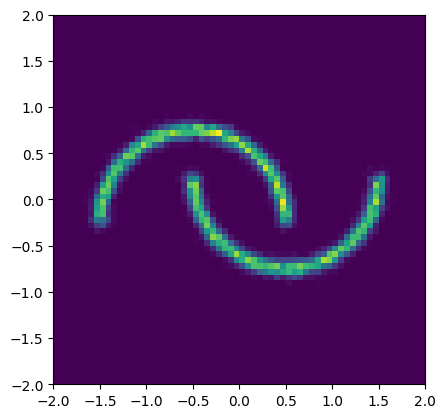

In [4]:

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

Now let's implement the interpolant to generate $x_t$ and check it visually

/tmp/ipykernel_293291/1333666029.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(x1).float()


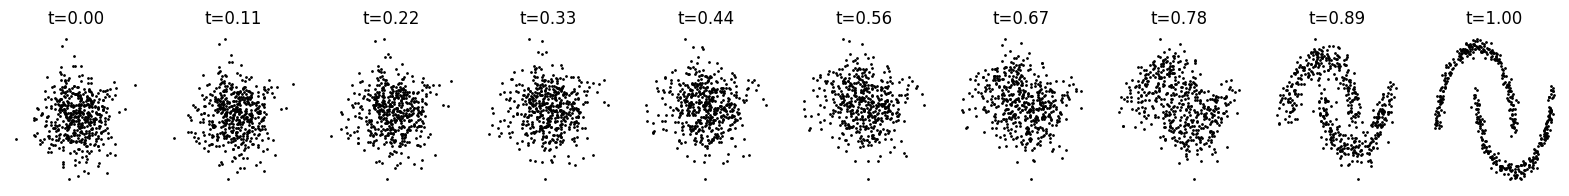

In [5]:
def interpolant(x0, x1, t):
    """
    #TODO:

    Implement the linear interpolation between noise (x0) and data (x1).
    
    At t=0: we should get pure noise (x0)
    At t=1: we should get real data (x1) 
    At t=0.5: we should get a 50/50 mix
    
    Args:
        x0: Starting point (noise), shape: (batch_size, ...)
        x1: End point (data), shape: (batch_size, ...)
        t: Time parameter, shape: (batch_size,) or scalar
        
    Returns:
        x_t: Interpolated samples at time t
    """
    # Your code here
    return (1 - t) * x0 + t * x1

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

x1, _ = two_moons(500,)
x1 = torch.tensor(x1).float()
x0  = torch.randn_like(x1)
t = torch.tensor(np.linspace(0., 1., 10))
for i, ax in enumerate(axs):
    xt = interpolant(x0,x1,t[i])
    ax.scatter(xt[:,0], xt[:,1],s=1, color='k')
    ax.axis('off')
    ax.set_title(f't={t[i]:.2f}')

As in the previous tutorial the velocity model will take $x_t$ and t as inputs, and predict the velocity

Let's write a neural network that can do this.

In [6]:
import torch.nn as nn

class VelocityNetwork(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        # TODO: Create a neural network that takes as input:
        # - 2D position (x_t): 2 dimensions  
        # - 1D time (t): 1 dimension
        # Total input: 3 dimensions
        # 
        # Output: 2D velocity vector
        #
        # Store this in self.net as a nn.Sequential
        
        #self.net = # Your code here
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),  # 2D position + 1D time
            nn.SiLU(),  # Smooth activation function
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 2)  # Output 2D velocity
        )

    def forward(self, xt, t):
        # TODO: Combine xt and t into a single input tensor and pass it through the 
        # velocity prediction network
        if t.dim() == 1:
            t = t.unsqueeze(1)
        xt = torch.cat([xt, t], dim=1)
        v = self.net(xt)
        return v



In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
velocity_nn = VelocityNetwork(
    hidden_dim=256,
).to(device)
t=torch.tensor(500*[0.5],dtype=torch.float32, device=device)

assert velocity_nn(
    xt=x1.to(device),
    t=t,
).shape == (500, 2), "Expected shape (500, 2) but got different shape"

Using device: cpu


**Now let's write down the flow matching model**:

Computing the loss is simple:

1. **Sample a random training pair**: Pick noise $x_0$ and real data $x_1$
2. **Pick a random time**: Choose $t$ uniformly between 0 and 1 to Monte Carlo estimate the expectation value over time.
3. **Get the interpolated data**: $x_t = (1-t)x_0 + tx_1$
4. **Evaluate the velocity prediction network**: "What velocity do you predict at $(x_t, t)$?"
5. **Compare with truth when knowing $x_1$**
6. **Update weights**: Use backpropagation to improve predictions


In [8]:
class FlowMatching(nn.Module):
    def __init__(self, velocity_network, device='cuda'):
        super().__init__()
        self.velocity_net = velocity_network
        self.device = device
        
    def sample_time(self, batch_size):
        """Sample random time steps between 0 and 1."""
        return torch.rand(batch_size, device=self.device)
    
    def interpolate(self, x0, x1, t):
        """
        Linear interpolation between noise (x0) and data (x1).
        At t=0: return x0 (noise)
        At t=1: return x1 (data)
        """
        # TODO: fill in the interpolant again
        t_shape = [t.size(0)] + [1] * (x1.dim() - 1)
        t = t.view(t_shape)
        return (1 - t) * x0 + t * x1
    
    def compute_target_velocity(self, x0, x1, t):
        """
        #TODO
        Compute the target velocity field that the neural network should learn.
        
        Think about this: if we have x_t = (1-t)*x0 + t*x1, 
        what is dx_t/dt (the derivative with respect to time)?
        """
        # Your code here
        #return # What is dx_t/dt?
        return x1 - x0
    
    def compute_loss(self, x1,):
        """
        Compute flow matching loss.
        
        Args:
            x1: data samples
        
        Returns:
            Loss value
        """
        # TODO: compute the flow matching loss given the functions above
        x0 = torch.randn_like(x1)
        t = self.sample_time(len(x1))
        
        xt = self.interpolate(x0, x1, t)
        
        target_velocity = self.compute_target_velocity(x0, x1, t)
        
        predicted_velocity = self.velocity_net(xt, t)
        
        loss = nn.MSELoss()(predicted_velocity, target_velocity)
        return loss
    
    def sample(self, target_shape=(2,), num_samples=10, num_steps=200,):
        """
        Generate samples by integrating the learned velocity field.
        
        Args:
            num_samples: Number of samples to generate
            num_steps: Number of integration steps
        
        Returns:
            Generated samples
        """
        self.velocity_net.eval()
        # TODO: Solve the ODE via Euler integration

        dt = 1.0 / num_steps
        x0 = torch.randn(num_samples, *target_shape, device=self.device)
        x = x0
        with torch.no_grad():
            # Integrate the velocity field from t=0 to t=1
            for i in range(num_steps):
                t = torch.full((num_samples,), i * dt, device=self.device)
                velocity = self.velocity_net(x, t )
                # Euler integration step
                x = x + velocity * dt
        return x

In [9]:
fm = FlowMatching(
    velocity_network=velocity_nn,
    device=device,
)


First, let's check that we can call compute_loss. If our data is standarized, we should expect a randomly initialized velocity network to return something of the order of 1. Always pay attention to the initial values of the loss funciton, as huge or tiny values usually indicate bugs.

In [10]:
fm.compute_loss(
    x1=x1.to(device),
)

tensor(1.5516, grad_fn=<MseLossBackward0>)

Now let's check the ODE solver code to generate new samples


In [11]:
samples = fm.sample(
   num_samples=500,

).cpu().numpy()

assert samples.shape == (500, 2), "Expected shape (500, 2) but got different shape"

If we plot them, they should look completely random given that the velocity network hasn't been trained yet

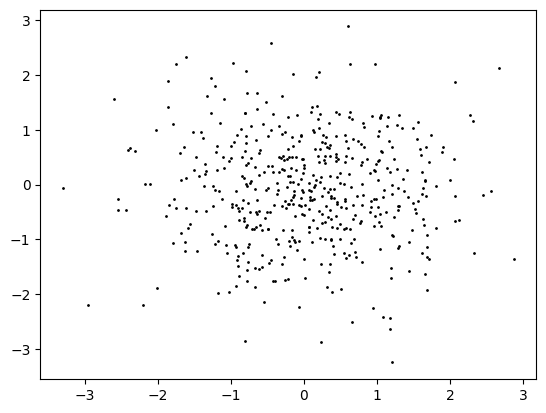

In [12]:
plt.scatter(
    samples[:,0],
    samples[:,1],
    c='k',
    s=1,
)

Now let's write the training loop to improve our currently very useless velocity model :)

In [13]:
from tqdm import tqdm
import torch.optim as optim
from IPython.display import clear_output


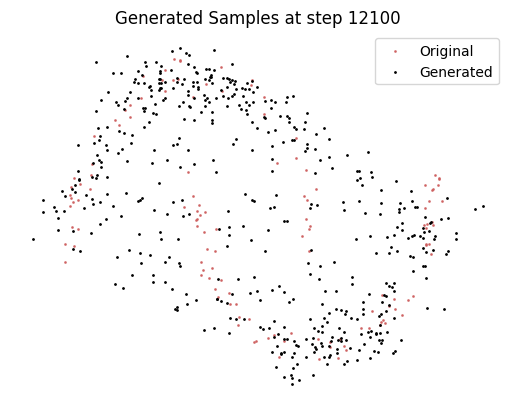

Training:  30%|███       | 12200/40000 [01:14<02:50, 162.93it/s, Loss=1.0079]



Generating samples at step 12200...


KeyboardInterrupt: 

In [14]:
optimizer = torch.optim.AdamW(fm.parameters(), lr=1.e-4, weight_decay=1e-4)
total_steps = 40_000
generate_every = 100
batch_size = 128
losses = []

fm.train()

step = 0 
with tqdm(total=total_steps, desc="Training") as pbar:
    while step < total_steps:
        x, label = two_moons(batch_size)
        x = x.to(device)  # Move data to device
        loss = fm.compute_loss(x).mean()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(fm.parameters(), max_norm=1.0)


        optimizer.step()
        optimizer.zero_grad()


        pbar.set_postfix({
                'Loss': f'{loss:.4f}',
            })
        pbar.update(1)
        step += 1
        losses.append(loss.detach())
        if step % generate_every == 0:
            print(f"\nGenerating samples at step {step}...")
            
            samples = fm.sample(
                num_samples=500, 
            ).detach().cpu().numpy()
            clear_output(wait=True)
            plt.scatter(
                x[:,0].cpu().numpy(),
                x[:,1].cpu().numpy(),
                c='indianred',
                s=1,
                alpha=0.8,
                label='Original'
            )
            plt.scatter(
                samples[:,0],
                samples[:,1],
                c='k',
                s=1,
                label='Generated'
            )
            plt.legend()
            plt.title(f'Generated Samples at step {step}')
            plt.axis('off')
 
            plt.show()

    losses = torch.stack(losses)




In [15]:
samples = fm.sample(
    num_samples=500, 
).detach().cpu().numpy()

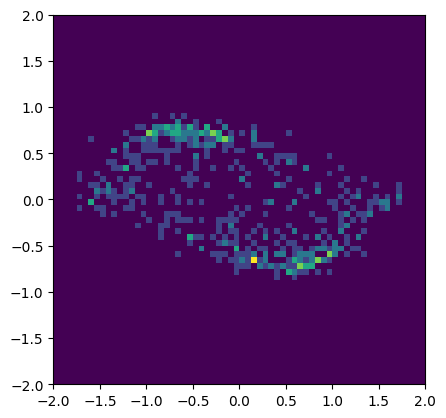

In [16]:

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-2, 2), (-2, 2)))
plt.show()

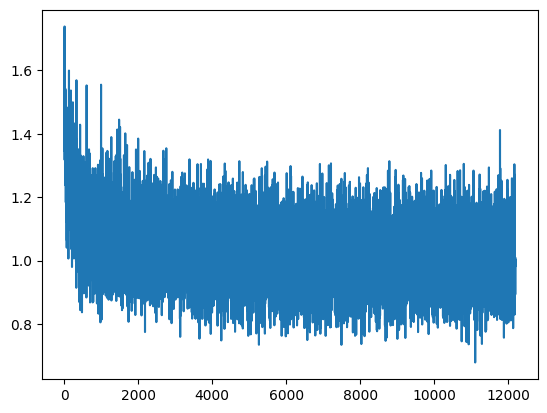

In [17]:
plt.plot(losses)